Note: This notebook contains only PCA-related functions written by me, and other essential helper functions to perform the trail-grouped PCA. 
I eliminated all the other EDA done by the original codes, so that it's cleaner to read and is easier to incorporate into one big file in the end.
The HeatMapTSegXBrainReg function from Pixel is modified a little bit by adding another input argument, so that it becomes more generalized. 

## Loading of Steinmetz data

includes some visualizations

In [1]:
# Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [16]:
# Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [17]:
dat['spks'].shape
NN = len(dat['brain_area'])
response = dat['response'] 
vis_right = dat['contrast_right'] 
vis_left = dat['contrast_left']
is_correct = np.sign(response)==np.sign(vis_left-vis_right)
large_margin = np.abs(vis_right - vis_left) > 0.49
print("correct:"+ str(np.sum(is_correct)))
print("incorrect:"+ str(np.sum(~is_correct)))
print("large margin:" + str(np.sum(large_margin)))
print("small margin:"+ str(np.sum(~large_margin)))

correct:236
incorrect:104
large margin:165
small margin:175


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [4]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

# Helper Functions
Note: Clamp427, VarHunter427 and HeatMap are provided by Pixel

In [ ]:
import copy

def smooth_dat(dat):
  """ Given a session of data: dat
      return the smoothed data, which is the firing rate for each recorded neuron
      by convolving the raw spikes counts data with a 1d gaussian filter
  Args:
    dat(dict): one session of data
  Return:
    dat_rate (dict): a deep copy of input data, with its raw spike counts data replaced
    by the spking rate data after convoling
  """

  dat_smoothed = copy.deepcopy(dat)
  for i in range(dat_smoothed['spks'].shape[0]):
    for j in range(dat_smoothed['spks'].shape[1]):
      spks = copy.deepcopy(dat['spks'][i][j])
      dat_smoothed['spks'][i][j] = np.convolve(spks, gaussian, 'same')

  return dat_smoothed


In [10]:
def Clamp427(val,min_val,max_val):
   return max(min(val,max_val),min_val)
   
def VarHunter427(dat, trial_ave = None, time_seg = None, nPC = 4):
  """ Given a session of data: dat
      print out variance explained using PCA on spike data by brain sub-regions
  Args:
    dat (np.arr):
      dat = alldat[s] s:= session number
    trial_ave (arr like object):
      trial number to average over; if None, then stack all time steps along all trials
    time_seg (slice object): # first 80 bins = 1.6 sec
      specify the slice of time (3rd dim in dat['spks']) over which PCA is done
    nPC (int):
      number of principal components
  Return:

  """
  nTimebins = dat['spks'].shape[-1] # number of bins
  if time_seg == None:
    time_seg == slice(51,130) # default
  list_var = list() # list of lists
  list_tot = list() # list of floats
  list_PC_NN = list() # list of len 2 tuples storing nPC and NN_
  brain_arr = list(set(dat['brain_area'])) # all unique brain_areas
  for str_ in brain_arr: # iterate over all unique brain_areas
      filter_ = np.isin(dat['brain_area'], [str_])
      NN_ = filter_.sum()
      # stack all of the time bins along trials (collapse dim 1 and 2)
      droll = np.reshape(dat['spks'][filter_][:,:,time_seg], (NN_,-1))
      droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
      nPC = Clamp427(nPC, 0, min(droll.shape[0],droll.shape[1])) # 0: n_features, 1: n_samples
      model = PCA(n_components = nPC).fit(droll.T)
      W = model.components_
      pc_10ms = W @ np.reshape(dat['spks'][filter_], (NN_,-1))
      pc_10ms = np.reshape(pc_10ms, (nPC, -1, nTimebins))
      variance_perc = model.explained_variance_ratio_
      tot_var = np.sum(variance_perc)
      list_var.append(variance_perc)
      list_tot.append(tot_var)
      list_PC_NN.append((nPC, droll.shape[0]))
  list_var = np.array(list_var)
  list_tot = np.array(list_tot)
  brain_arr = np.array(brain_arr)
  list_PC_NN = np.array(list_PC_NN)

  by_totnPC = np.argsort(list_tot)[::-1] # descending order
  list_var = list_var[by_totnPC]
  list_tot = list_tot[by_totnPC]
  brain_arr = brain_arr[by_totnPC]
  list_PC_NN = list_PC_NN[by_totnPC]
  for i in range(len(list_tot)):
      print('region: ', brain_arr[i].ljust(5), 'PC:n_features ' \
            , list_PC_NN[i][0], ':', str(list_PC_NN[i][1]).ljust(4) \
            , 'total: %.3f' %list_tot[i], 'var explained: ', list_var[i])
  

In [33]:
def HeatMapTSegXBrainReg(PCperSlice_regions, brain_arr, x_labels, choice_PC = [0,1,2,3]):
  """
    Args:
    PCperSlice_regions (np.arr; (nSlice, nPC, len(brain_arr)):
      nSlice: slice of data on which PCA is performed (x-axis of the heatmaps)
      nPC: number of PC = number of heatmaps
      len(brain_arr): number of regions after collapsing all neurons into subgroups
    brain_arr (list):
      string name for brain regions / or str(index) for each neuron in given region
      (in the latter case the y-axis will just be all neurons in given region)
      size of which should be equal to the PCperSlice_regions.shape[2]
    x_labels (list):
      string name for different trails groups on the x-axis
    choice_PC (1D array like object):
      PC index to display heat map on
  """
  xLen = PCperSlice_regions.shape[0] # x is time segment slices
  yLen = PCperSlice_regions.shape[2] # y is brain region
  
  #fig, ax = plt.subplots() # create a plot
  fig, axs = plt.subplots(1, len(choice_PC), figsize=(20, 9))
  # do min(4,nPC) components
  for pc in range(len(choice_PC)):
    theMatrix = PCperSlice_regions[:,choice_PC[pc],:].T # transpose it
    im = axs[pc].imshow(theMatrix)
    # show all ticks & labels
    """
    # Create colorbar
    cbar_kw = {}
    cbar = fig.colorbar(im, ax=axs[pc], **cbar_kw)
    cbar.ax.set_ylabel('PC weights', rotation=-90, va="bottom")
    """
    axs[pc].set_xticks(np.arange(xLen))
    axs[pc].set_yticks(np.arange(yLen))
    axs[pc].set_xticklabels(x_labels)
    axs[pc].set_yticklabels(brain_arr)
    # Rotate the tick labels and set their alignment
    plt.setp(axs[pc].get_xticklabels(), rotation=70, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    """
    for y in range(yLen): # row of theMatrix
        for x in range(xLen): # col of theMatrix
            text = axs[pc].text(x, y, theMatrix[y, x],
                          ha="center", va="center", color="w")
    """
    axs[pc].set_title("PC {p:.0f}".format(p = choice_PC[pc] + 1))
  # Create colorbar
  clb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 0.42)
  clb.ax.set_ylabel('PC weights', rotation=-90, va="bottom")
  clb.ax.set_anchor((1,0.5))
  #fig.tight_layout()
  plt.show()

In [ ]:
VarHunter427(dat)

# PCA by Trail Groups

Note: 
1. VarHunter could be used to do sanity check on the variance explained
2. Y-axis of the heat map: brain regions could be sorted by the magnitude of the weights or by number of neurons

In [34]:
from sklearn.decomposition import PCA 

def FindNumOfNeurons(dat):
  """ Given one session, returns the number of neurons in each
      of the brain regions it records from.
  Args:
      dat (dict): contains all recording information from one single session,
                  including the brain area of each recorded neuron.
  Return:
      NN (dict): a dictionary contains all the recorded brain regions in one session
                 as the key, and number of neurons in each of these regions
  """

  barea = dat['brain_area']
  NN = {}
  for i in range(len(barea)):
    if barea[i] not in NN:
      NN[barea[i]] = 0
    NN[barea[i]] += 1
  return NN



def PCAbyTrailGroup(spks, n_component):
  """ Given dat, perform PCA on its spks
  Args: 
      spks
  Return:
      W (list, shape(n_component, n_neurons)): 
      weights of PCs with our specified number of components, 
  """
  droll = np.reshape(spks[:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
  droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
  model = PCA(n_component).fit(droll.T)
  W = model.components_
  return W



def Region_Averaged_PC_weights(W, params):
  """ Given the weights of all PCs of interest, compute the brain region-averaged 
      PC weights for each of the PC.
  Args:
      W ((n_component, NN) array): weights of PCs of interest
      params (dict): contains a list of brain area and a list of number of neurons in each area
  Return:
      w_by_region ((n_component, num_brain_area) array)
  """ 
  barea = params['barea']
  num_neurons = params['num_neurons']
  w_by_region = []
  for PC in W:
    w_per_PC = []
    for area in barea:
      local_neurons = dat['brain_area'] == area 
      w_per_PC.append(np.sum(local_neurons * PC))
    for i in range(len(w_per_PC)):
      w_per_PC[i] /= num_neurons[i]
    w_by_region.append(w_per_PC)
  return barea, w_by_region


In [49]:
def PCA_HeatMap_by_TrailGroup(dat):
  """ Given dat, first seperate all trails to correct/incorrect, large/small margin groups,
      then perform a PCA on each of these four conditions, and produce a heatmap on brain
      region averaged weights of PC for correct/incorrect, and large/small margin group.
  Args:
      dat (dict): one session of recording.
  Returns:
      Two groups of heatmaps performed on correct/incorrect trails, and large/small margin 
      trails, respectively. Each group of heatmap contains 4 seperate heatmaps corresponding 
      to top 4 PCs sorted by descending variance explained. The Y-axis of each heatmap
      labels different brain regions in the input session, sorted by descending number of 
      recorded neurons. The X-axis is different trail groups. 
  """

  # preprocessing for PCA
  spks = dat['spks']
  response = dat['response']
  vis_left = dat['contrast_left']
  vis_right = dat['contrast_right']
  is_correct = np.sign(response)==np.sign(vis_left-vis_right)
  large_margin = np.abs(vis_left - vis_right) > 0.49

  # perform PCA on each of correct/incorrect, large/small margin trails
  # plotting the variance explained by the top few PCs
  w_cor = PCAbyTrailGroup(spks[:, is_correct, :], 4)        # PCA on correct trail group
  w_incor = PCAbyTrailGroup(spks[:, ~is_correct, :], 4)     # PCA on incorrect trail group
  w_lar_margin = PCAbyTrailGroup(spks[:, large_margin, :], 4)   # PCA on large margin trial group
  w_smal_margin = PCAbyTrailGroup(spks[:, ~large_margin, :], 4) # PCA on small margin trail group

  # sort both the weights and the barea by descending number of neurons within each region
  barea_dict = FindNumOfNeurons(dat)
  barea_keys = list(FindNumOfNeurons(dat).keys())
  barea = []
  num_neurons = sorted(FindNumOfNeurons(dat).values(), reverse=True)  # sort the number of neurons
  for i in range(len(num_neurons)):
    for j in range(len(barea_keys)):
      if barea_dict[barea_keys[j]] == num_neurons[i]:
        barea.append(barea_keys[j])
  params = {'barea': barea, 'num_neurons': num_neurons}

  # average PC weights by brain regions for each of four trail groups
  barea_cor, w_cor_aver     =  Region_Averaged_PC_weights(w_cor, params)
  barea_incor, w_incor_aver =  Region_Averaged_PC_weights(w_incor, params)
  barea_lar, w_lar_aver     =  Region_Averaged_PC_weights(w_lar_margin, params)
  barea_smal, w_smal_aver   =  Region_Averaged_PC_weights(w_smal_margin, params)

  # converting region-averaged weights to Heatmap
  w_cor_incor = np.array([w_cor_aver, w_incor_aver])
  w_lar_smal_margin = np.array([w_lar_aver, w_smal_aver])
  x_label_cor = ['correct', 'incorrect']
  x_label_mar = ['large margin', 'small margin']
  HeatMapTSegXBrainReg(w_cor_incor, barea, x_label_cor, choice_PC = [0,1,2,3])
  HeatMapTSegXBrainReg(w_lar_smal_margin, barea, x_label_mar, choice_PC = [0,1,2,3])

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


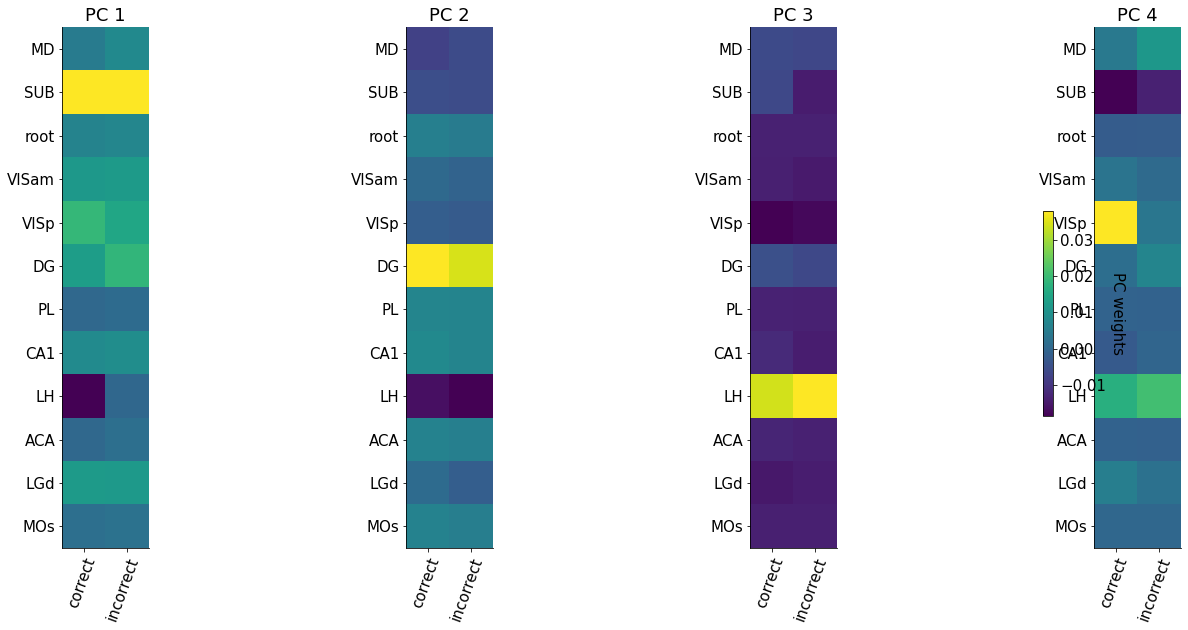

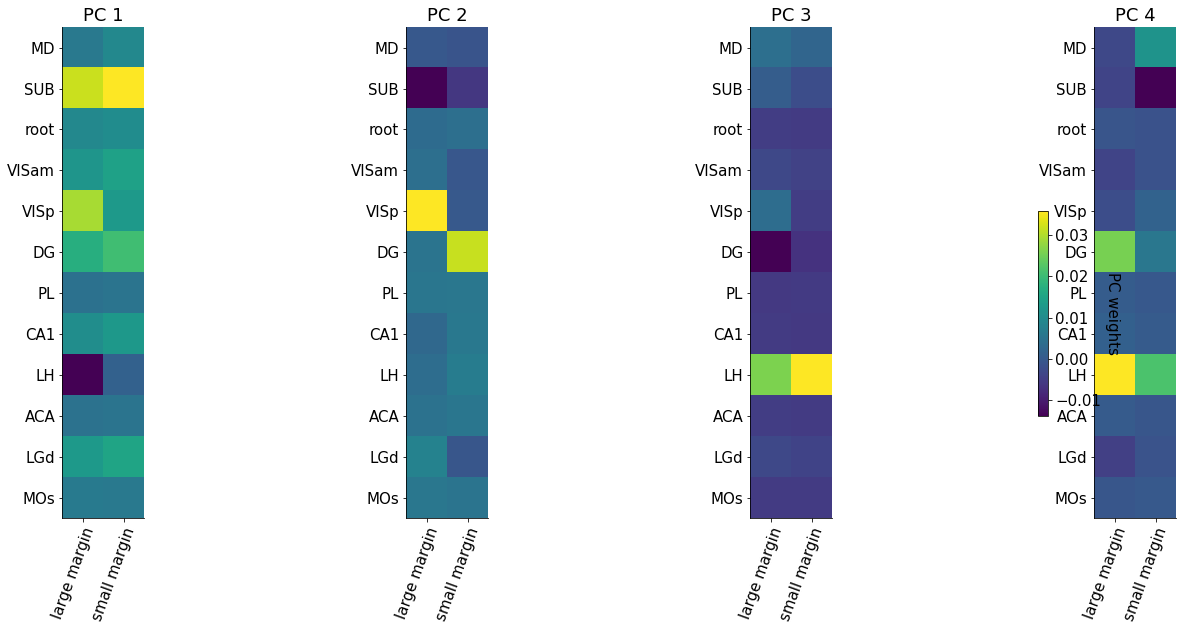

In [50]:
PCA_HeatMap_by_TrailGroup(dat)